MNIST Training Set: 60000 samples
MNIST Test Set: 10000 samples


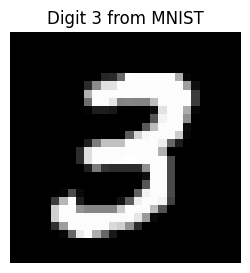


Total MNIST samples: 60000

After splitting:
Training samples: 54000
Validation samples: 6000

MNIST Dataset:
----------------------------------------
MNIST Train                    :   60,000 samples
MNIST Test                     :   10,000 samples

After Train/Val Split:
----------------------------------------
Training Set                   :   54,000 samples
Validation Set                 :    6,000 samples

Applying Elastic, Gaussian Noise, CoarseDropout, + Minimal Color Variation ...


/tmp/ipykernel_187129/2722452502.py:252: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 20), p=0.2),
/tmp/ipykernel_187129/2722452502.py:253: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


Original training size: 54000 | After augmentation: 108000

After augmentation (per epoch):
Training samples (now doubled): 108000
Augmented samples per epoch: 107776
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7481 - loss: 3.1366

422/422 ━━━━━━━━━━━━━━━━━━━━ 202s 465ms/step - accuracy: 0.7483 - loss: 3.1331 - val_accuracy: 0.8995 - val_loss: 0.5429 - learning_rate: 0.0010
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9324 - loss: 0.3978

422/422 ━━━━━━━━━━━━━━━━━━━━ 196s 464ms/step - accuracy: 0.9324 - loss: 0.3978 - val_accuracy: 0.9903 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 196s 465ms/step - accuracy: 0.9462 - loss: 0.3259 - val_accuracy: 0.9887 - val_loss: 0.1882 - learning_rate: 0.0010
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9532 - loss: 0.3077

422/422 ━━━━━━━━━━━━━━━━━━━━ 196s 463ms/step - accuracy: 0.9532 - loss: 0.3077 - val_accuracy: 0.9910 - val_loss: 0.1842 - learning_rate: 0.0010
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 196s 465ms/step - accuracy: 0.9561 - loss: 0.2897 - val_accuracy: 0.9882 - val_loss: 0.1867 - learning_rate: 0.0010


In [6]:
import os

import numpy as np
import tensorflow as tf
from kaggle.api.kaggle_api_extended import KaggleApi
from kagglehub import KaggleDatasetAdapter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, MaxPool2D,
                                     SpatialDropout2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# ========== NEW IMPORTS FOR ELASTIC TRANSFORM + GAUSSIAN NOISE + COARSEDROPOUT + COLOR TRANSFORMS ==========
import albumentations as A
import cv2
# ========================================================

# Create consistent directory structure
BASE_DATA_DIR = 'data'
DATASETS: dict[str, str] = {
    'mnist': os.path.join(BASE_DATA_DIR, 'mnist'),
    'emnist': os.path.join(BASE_DATA_DIR, 'emnist'),
    'handwritten_digits': os.path.join(BASE_DATA_DIR, 'handwritten-digits-not-mnist'),
    'usps': os.path.join(BASE_DATA_DIR, 'usps'),
    'models': os.path.join(BASE_DATA_DIR, 'models')
}

for directory in DATASETS.values():
    os.makedirs(directory, exist_ok=True)

def print_dataset_summary(dataset_name, count):
    print(f"{dataset_name:<30} : {count:>8,d} samples")
    

def print_class_distribution(labels, dataset_name):
    """Print distribution of classes in a dataset"""
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{dataset_name} class distribution:")
    for digit, count in zip(unique, counts):
        print(f"Digit {digit}: {count} samples")
    print(f"Total samples: {len(labels)}")

def print_total_samples(labels, dataset_name):
    """Print only total samples in a dataset"""
    print(f"{dataset_name}: {len(labels)} samples")

def show_digit_3(images, labels, dataset_name):
    """Display first occurrence of digit 3 in dataset"""
    idx = np.where(labels == 3)[0][0]
    plt.figure(figsize=(3, 3))
    plt.imshow(images[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Digit 3 from {dataset_name}')
    plt.axis('off')
    plt.show()

def load_mnist_data():
    (x_train, labels_train), (x_test, labels_test) = mnist.load_data()
    print_total_samples(labels_train, "MNIST Training Set")
    print_total_samples(labels_test, "MNIST Test Set")
    
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    show_digit_3(x_train, labels_train, "MNIST")
    
    return x_train, labels_train, x_test, labels_test

def load_handwritten_digits():
    images = []
    labels = []
    dataset_path = os.path.join(DATASETS['handwritten_digits'], 'dataset')
    
    print(f"\nProcessing Handwritten Digits Dataset (not in MNIST) from: {dataset_path}")
    
    for label in range(10):
        folder_path = os.path.join(dataset_path, str(label), str(label))
        if not os.path.exists(folder_path):
            print(f"Warning: Missing directory for label {label} - {folder_path}")
            continue
            
        file_count = len([name for name in os.listdir(folder_path) if name.endswith('.png')])
        print(f"Processing {file_count} samples for digit {label}")
        
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                img_path = os.path.join(folder_path, filename)
                try:
                    with Image.open(img_path).convert("RGBA") as rgba_img:
                        bg = Image.new("RGBA", rgba_img.size, (255, 255, 255, 255))
                        bg.paste(rgba_img, (0, 0), rgba_img)
                        img = bg.convert('L')
                    
                    img = img.resize((28, 28))
                    
                    img_array = np.array(img).astype('float32') / 255.0
                    # invert so digits are white on black
                    img_array = 1.0 - img_array  
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
                    continue
                
    images = np.array(images)
    labels = np.array(labels)
    
    show_digit_3(images, labels, "Handwritten (not MNIST)")
    
    return images, labels

def load_emnist_data():
    train_file = os.path.join(DATASETS['emnist'], 'emnist-digits-train.csv')
    
    try:
        if not os.path.exists(train_file):
            print(f"Error: EMNIST data file not found at {train_file}")
            print("\nAvailable files in EMNIST directory:")
            for file in os.listdir(DATASETS['emnist']):
                print(f"- {file}")
            raise FileNotFoundError(f"EMNIST data file not found at {train_file}")
        
        print(f"Loading EMNIST data from: {train_file}")
        
        import pandas as pd
        data = pd.read_csv(train_file)
        
        if data.empty:
            raise ValueError("Loaded CSV file is empty")
        
        labels = data.iloc[:, 0].values
        pixels = data.iloc[:, 1:].values
        
        images = pixels.reshape(-1, 28, 28)
        images = images.transpose(0, 2, 1)
        images = np.flip(images, axis=1)
        
        images = images.astype('float32') / 255.0
        
        show_digit_3(images, labels, "EMNIST")
        
        return images, labels
        
    except Exception as e:
        print(f"Error loading EMNIST data: {str(e)}")
        return None, None

def load_usps_data():
    import h5py
    usps_path = os.path.join(DATASETS['usps'], 'usps.h5')
    
    if not os.path.exists(usps_path):
        raise FileNotFoundError(f"USPS dataset file not found at {usps_path}")
        
    print(f"Loading USPS data from {usps_path}")
    
    with h5py.File(usps_path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get('data')[:]
        y_train = train.get('target')[:]
    
    from skimage.transform import resize
    print("Resizing USPS images from 16x16 to 28x28...")
    resized_images = []
    for img in X_train:
        img = img.reshape(16, 16)
        img_resized = resize(img, (28, 28), anti_aliasing=True)
        resized_images.append(img_resized)
    
    images = np.array(resized_images)
    images = images.astype('float32')
    if images.max() > 1.0:
        images /= 255.0
    
    show_digit_3(images, y_train, "USPS")
    
    return images, y_train

def prepare_data():
    x_train_mnist, labels_train_mnist, x_test, labels_test = load_mnist_data()
    x_train_mnist = x_train_mnist.reshape(-1, 28, 28, 1)
    y_train_mnist = tf.keras.utils.to_categorical(labels_train_mnist, 10)
    
    handwritten_images, handwritten_labels = load_handwritten_digits()
    handwritten_images = handwritten_images.reshape(-1, 28, 28, 1)
    handwritten_labels_cat = tf.keras.utils.to_categorical(handwritten_labels, 10)
    
    emnist_images, emnist_labels = load_emnist_data()
    emnist_images = emnist_images.reshape(-1, 28, 28, 1)
    emnist_labels_cat = tf.keras.utils.to_categorical(emnist_labels, 10)
    
    usps_images, usps_labels = load_usps_data()
    usps_images = usps_images.reshape(-1, 28, 28, 1)
    usps_labels_cat = tf.keras.utils.to_categorical(usps_labels, 10)
    
    x_train_combined = np.concatenate([
        x_train_mnist, 
        handwritten_images, 
        emnist_images, 
        usps_images
    ])
    y_train_combined = np.concatenate([
        y_train_mnist, 
        handwritten_labels_cat, 
        emnist_labels_cat, 
        usps_labels_cat
    ])
    
    print(f"\nTotal combined samples: {len(x_train_combined)}")
    
    x_train_combined, y_train_combined = shuffle(
        x_train_combined, 
        y_train_combined, 
        random_state=42
    )
    
    x_train, x_val, y_train, y_val = train_test_split(
        x_train_combined, 
        y_train_combined, 
        test_size=0.1, 
        random_state=42
    )
    
    print(f"\nAfter splitting:")
    print(f"Training samples: {len(x_train)}")
    print(f"Validation samples: {len(x_val)}")
    
    print("\nOriginal Datasets:")
    print("-" * 40)
    print_dataset_summary("MNIST Train", len(labels_train_mnist))
    print_dataset_summary("MNIST Test", len(labels_test))
    print_dataset_summary("Handwritten Digits (not MNIST)", len(handwritten_labels))
    print_dataset_summary("EMNIST", len(emnist_labels))
    print_dataset_summary("USPS", len(usps_labels))
    
    total_samples = len(x_train_combined)
    print("\nCombined Dataset:")
    print("-" * 40)
    print_dataset_summary("Total Combined", total_samples)
    
    print("\nAfter Train/Val Split:")
    print("-" * 40)
    print_dataset_summary("Training Set", len(x_train))
    print_dataset_summary("Validation Set", len(x_val))
    
    return x_train, y_train, x_val, y_val

# Prepare data
x_train, y_train, x_val, y_val = prepare_data()

# ========== OFFLINE AUGMENTATION BLOCK (ELASTIC + GAUSS NOISE + COARSEDROPOUT + COLOR SHIFTS) ==========
print("\nApplying Elastic, Gaussian Noise, CoarseDropout, + Minimal Color Variation ...")

# Combine transforms into one Compose:
# - 100% chance (p=1.0) for ElasticTransform
# - 20% chance (p=0.2) for GaussNoise
# - 15% chance (p=0.15) for small 4x4 dropout
# - 10% chance (p=0.1) for brightness/contrast
# - 5% chance (p=0.05) to invert image
augmentation_transform = A.Compose([
    A.ElasticTransform(alpha=50, sigma=5, p=1.0),
    A.GaussNoise(var_limit=(10, 20), p=0.2),
    A.CoarseDropout(
        max_holes=1,
        max_height=4,
        max_width=4,
        fill_value=0.0,
        p=0.15
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,  # ±20% brightness
        contrast_limit=0.2,
        p=0.1
    ),
    A.InvertImg(p=0.05)
])

augmented_images = []
augmented_labels = []

for i in range(len(x_train)):
    image_0_1 = x_train[i, :, :, 0]
    image_255 = (image_0_1 * 255).astype(np.uint8)

    # Apply Albumentations pipeline
    augmented = augmentation_transform(image=image_255)
    aug_img_255 = augmented["image"]

    # Convert back to float [0,1], expand dims
    aug_img_01 = aug_img_255.astype(np.float32) / 255.0
    aug_img_01 = np.expand_dims(aug_img_01, axis=-1)

    augmented_images.append(aug_img_01)
    augmented_labels.append(y_train[i])

augmented_images = np.array(augmented_images, dtype=np.float32)
augmented_labels = np.array(augmented_labels)

# Concatenate original + augmented
original_size = len(x_train)
x_train = np.concatenate([x_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_labels], axis=0)

print(f"Original training size: {original_size} | After augmentation: {len(x_train)}")
# ============================================================

# Keras ImageDataGenerator for on-the-fly augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

steps_per_epoch = len(x_train) // 256
print(f"\nAfter augmentation (per epoch):")
print(f"Training samples (now doubled): {len(x_train)}")
print(f"Augmented samples per epoch: {steps_per_epoch * 256}")

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2)),
    SpatialDropout2D(0.2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2)),
    SpatialDropout2D(0.2),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        os.path.join(DATASETS['models'], 'best_model.h5'),
        save_best_only=True,
        monitor='val_accuracy'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=256),
    validation_data=(x_val, y_val),
    epochs=5,
    callbacks=callbacks
)

model.save(os.path.join(DATASETS['models'], 'final_model.h5'))
